# House Prices Advanced Regression - Modeling Notebook
## XGBoost and Random Forest Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_palette('husl')
%matplotlib inline

# 2. Load processed data

In [2]:
try:
    X_train = pd.read_csv('../processed_data/X_train_processed.csv')
    y_train = pd.read_csv('../processed_data/y_train.csv').values.ravel()
    X_test = pd.read_csv('../processed_data/X_test_processed.csv')
    print("Data loaded successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Data loaded successfully!
X_train shape: (1458, 77)
y_train shape: (1458,)
X_test shape: (1459, 77)


# 3. Train/Validation split

In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)
print("\nData split:")
print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Data split:
Train set: (1020, 77)
Validation set: (438, 77)


# 4. Evaluation metrics

In [4]:
def evaluate_model(y_true, y_pred, model_name=""):
    """Calculate and display evaluation metrics"""
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'R2': r2_score(y_true, y_pred)
    }
    
    print(f"\n{model_name} Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    
    return metrics

## Random Forest Model

In [5]:
rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

rf_params = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining Random Forest model...")
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("\nBest Random Forest parameters:")
print(rf_grid.best_params_)

y_pred_rf = best_rf.predict(X_val)
rf_metrics = evaluate_model(y_val, y_pred_rf, "Random Forest")


Training Random Forest model...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Random Forest parameters:
{'randomforestregressor__max_depth': None, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 200}

Random Forest Metrics:
MAE: 15857.5536
RMSE: 23718.0311
RMSLE: 0.1393
R2: 0.9032


# 6. RF Feature Importance

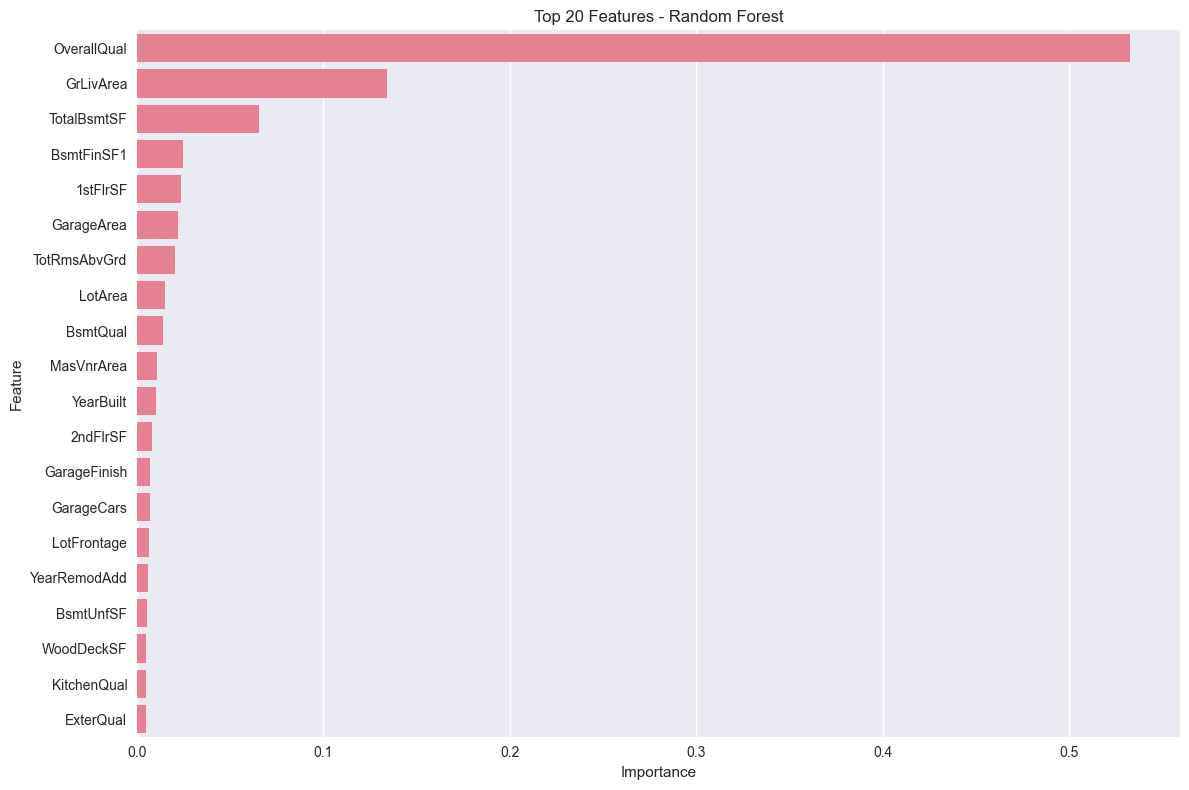

In [6]:
rf_feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.named_steps['randomforestregressor'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_imp.head(20))
plt.title('Top 20 Features - Random Forest')
plt.tight_layout()
plt.show()

## 7. XGBoost Model

In [7]:
xgb_pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
)

xgb_params = {
    'xgbregressor__n_estimators': [100, 200],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__subsample': [0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining XGBoost model...")
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("\nBest XGBoost parameters:")
print(xgb_grid.best_params_)

y_pred_xgb = best_xgb.predict(X_val)
xgb_metrics = evaluate_model(y_val, y_pred_xgb, "XGBoost")


Training XGBoost model...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best XGBoost parameters:
{'xgbregressor__colsample_bytree': 0.8, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 200, 'xgbregressor__subsample': 0.8}

XGBoost Metrics:
MAE: 15169.0485
RMSE: 21960.8173
RMSLE: 0.1182
R2: 0.9170


# 8. XGBoost Feature Importance

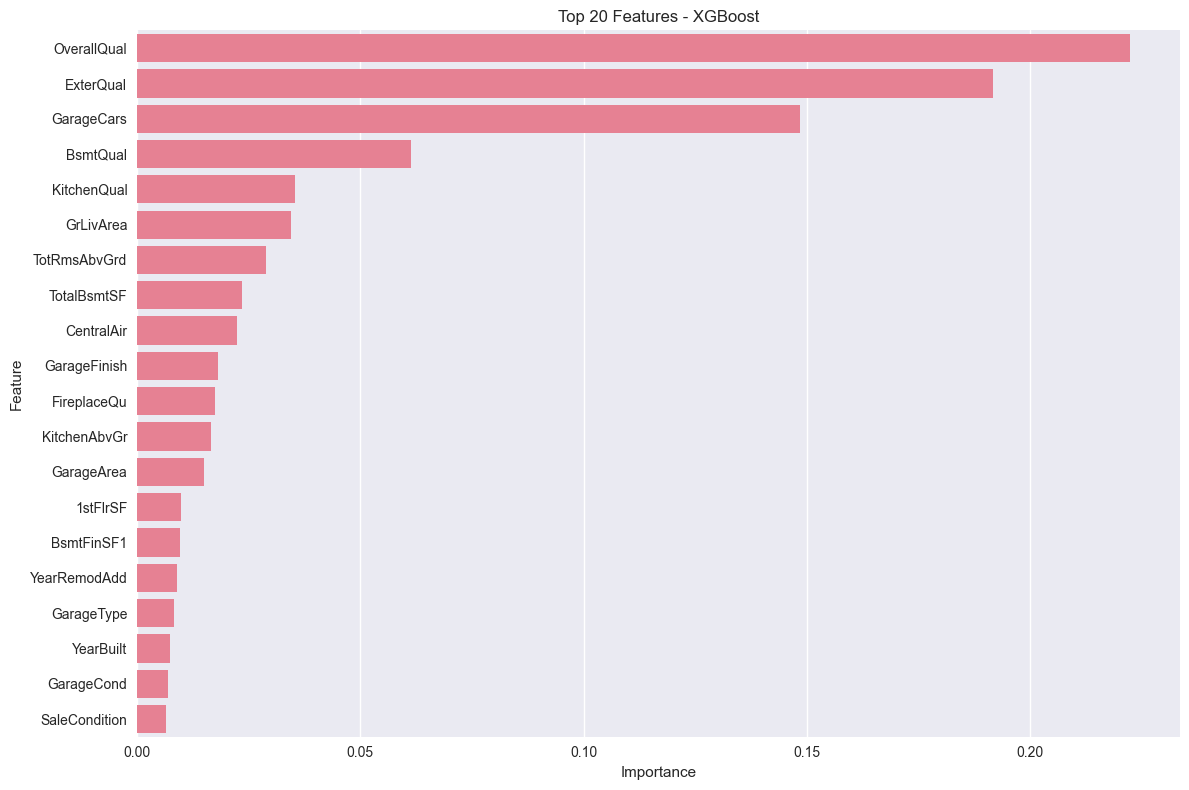

In [8]:
xgb_feature_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.named_steps['xgbregressor'].feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_imp.head(20))
plt.title('Top 20 Features - XGBoost')
plt.tight_layout()
plt.show()

## 9. Model Comparison and Ensemble

In [9]:
y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2
ensemble_metrics = evaluate_model(y_val, y_pred_ensemble, "Ensemble (RF + XGB)")

metrics_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics,
    'Ensemble': ensemble_metrics
}).T

print("\nModel Comparison:")
print(metrics_df)


Ensemble (RF + XGB) Metrics:
MAE: 14805.3265
RMSE: 21918.6952
RMSLE: 0.1239
R2: 0.9174

Model Comparison:
                        MAE          RMSE     RMSLE        R2
Random Forest  15857.553607  23718.031119  0.139294  0.903237
XGBoost        15169.048454  21960.817293  0.118159  0.917044
Ensemble       14805.326496  21918.695165  0.123934  0.917362


# 10. Visualization of predictions

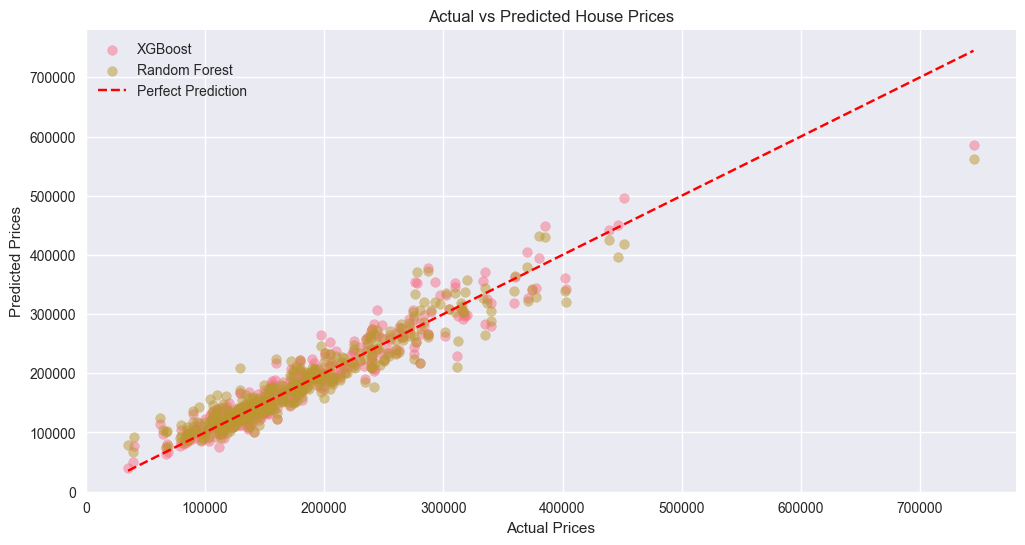

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_xgb, alpha=0.5, label='XGBoost')
plt.scatter(y_val, y_pred_rf, alpha=0.5, label='Random Forest')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted House Prices')
plt.legend()
plt.grid(True)
plt.show()

## 11. Train final model on full training data

In [11]:
final_model = make_pipeline(
    StandardScaler(),
    XGBRegressor(
        **{k.replace('xgbregressor__', ''): v for k, v in xgb_grid.best_params_.items()},
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
)

print("\nTraining final model on full training data...")
final_model.fit(X_train, y_train)


Training final model on full training data...


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=-1, num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

# 12. Make predictions on test set

In [12]:
test_predictions = final_model.predict(X_test)

# 13. Prepare submission file

In [13]:
submission = pd.DataFrame({
    'Id': range(1461, 1461 + len(X_test)),
    'SalePrice': test_predictions
})

submission_path = '../processed_data/submission_final.csv'
submission.to_csv(submission_path, index=False)
print(f"\nSubmission file saved to: {submission_path}")


Submission file saved to: ../processed_data/submission_final.csv


## 14. Cross Validation

In [14]:

def cross_validate_model(model, X, y, cv=5):
    """Perform cross validation and display results"""
    scores = cross_val_score(
        model, X, y, 
        cv=cv, 
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rmse_scores = np.sqrt(-scores)
    
    print(f"\n{cv}-fold Cross Validation Results:")
    print(f"Mean RMSE: {rmse_scores.mean():.4f}")
    print(f"Std Dev: {rmse_scores.std():.4f}")
    
    return rmse_scores

# Perform CV on final model
cv_scores = cross_validate_model(final_model, X_train, y_train)


5-fold Cross Validation Results:
Mean RMSE: 24885.5495
Std Dev: 2431.6505


## 15. Residual Analysis

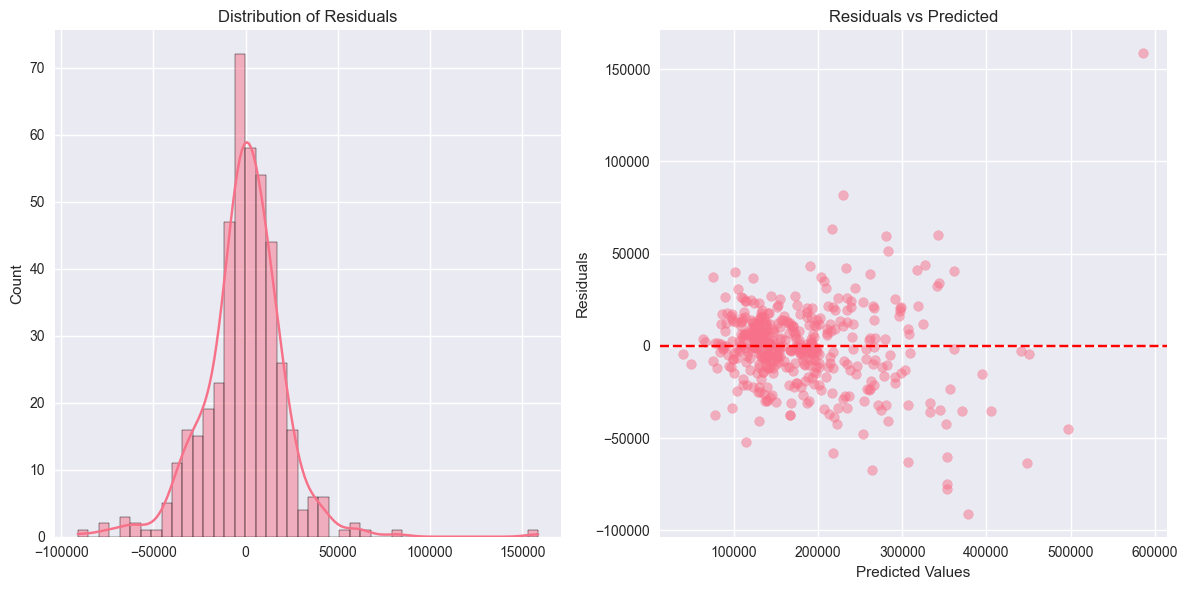

In [15]:
residuals = y_val - y_pred_xgb

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')

plt.subplot(1, 2, 2)
plt.scatter(y_pred_xgb, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

## 16. Conclusion - Final comparison

In [16]:
print("\nFinal Model Comparison:")
print(metrics_df)

best_model = metrics_df['RMSLE'].idxmin()
print(f"\nBest model based on RMSLE: {best_model}")
print(f"RMSLE: {metrics_df.loc[best_model, 'RMSLE']:.4f}")

print("\nModeling process completed successfully!")


Final Model Comparison:
                        MAE          RMSE     RMSLE        R2
Random Forest  15857.553607  23718.031119  0.139294  0.903237
XGBoost        15169.048454  21960.817293  0.118159  0.917044
Ensemble       14805.326496  21918.695165  0.123934  0.917362

Best model based on RMSLE: XGBoost
RMSLE: 0.1182

Modeling process completed successfully!
